# An example using Feature weighted ECM clustering


In [21]:
## Importing
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import numpy as np
import matplotlib.pyplot as plt
from evclust.ecm import ecm
from evclust.fwecm import fwecm
from evclust.utils import ev_summary, ev_plot, ev_pcaplot
import pandas as pd
from sklearn.metrics import adjusted_rand_score, silhouette_score
import seaborn as sns
from evclust.datasets import load_2d_dataset



In [22]:
def get_ensembles(table):
    result = []
    for row in table:
        row_str = 'Cl_' + '_'.join([str(i + 1) if elem == 1 else str(int(elem)) for i, elem in enumerate(row) if elem != 0])
        result.append(row_str)

    result[0] = 'Cl_atypique'
    result[-1] = 'Cl_incertains'

    cleaned_result = [''.join(ch for i, ch in enumerate(row_str) if ch != '_' or (i > 0 and row_str[i-1] != '_')) for row_str in result]

    return cleaned_result

def ev_plot_2D(data, x, normalize=False, splite=False, cex=8, cex_protos=5):
    mas = pd.DataFrame(x["mass"])
    c = len(np.unique(x['y_pl']))
    cols = get_ensembles(x['F'])
    mas.columns = cols
    mas["Cluster"] = mas.apply(lambda row: row.idxmax(), axis=1)

    # pca = PCA(n_components=2)
    # pca_result = pca.fit_transform(data)

    # variance_percent = np.round(pca.explained_variance_ratio_ * 100, 1)

    ind_coord = pd.DataFrame(data, columns=["Dim.1", "Dim.2"])
    ind_coord["Cluster"] = pd.Categorical(mas["Cluster"])
    mean_coords = ind_coord.groupby('Cluster').mean()

    pcolor = sns.color_palette("Dark2", n_colors=len(ind_coord["Cluster"].unique()))
    plt.figure(figsize=(8, 6))

    if splite:
        sns.relplot(data=ind_coord, x="Dim.1", y="Dim.2", hue="Cluster", col="Cluster",
                    style="Cluster", palette=pcolor, s=cex, col_wrap=int((c ** 2) / 2))
    else:
        sns.scatterplot(data=ind_coord, x="Dim.1", y="Dim.2", hue="Cluster", palette=pcolor,
                        style="Cluster", s=cex)
        sns.scatterplot(data=mean_coords, x="Dim.1", y="Dim.2", s=(cex + 25), hue="Cluster",
                        palette=pcolor, style="Cluster", legend=False)

    sns.despine()
    legend = plt.legend(title="Cluster", loc='upper left', markerscale=0.3)
    plt.setp(legend.get_title(), fontsize=7)
    plt.setp(legend.get_texts(), fontsize=7)
    plt.tick_params(axis='both', labelsize=7)
    plt.axis('equal')
    plt.show()
    
def credal_partition_contour_lines(model, X, marker_list):
    mass = model['mass']
    clusters = np.argmax(mass, axis=1)
    contour_list = np.array([])
    datapoint_list = []
    for i in range(mass.shape[1]):
        indices = np.where(clusters == i)
        datapoints = X[indices]
        if len(datapoints) > 3:
            datapoint_list.append(datapoints)
            memberships = mass[indices, i].ravel()
            contour = plt.tricontourf(datapoints[:, 0], datapoints[:, 1], memberships, cmap='viridis', alpha=0.6)
            contour_list = np.append(contour_list, contour)
    
    plt.colorbar(contour_list[0], label='Mass value')
    
    for i in range(len(marker_list)):
        datapoints = datapoint_list[i]
        plt.scatter(datapoints[:, 0], datapoints[:, 1], marker=marker_list[i], s=20)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Credal partition')
    plt.xlim(-2, 7)
    plt.ylim(1, 9)
    plt.show()

In [23]:
# Non-specificity values
def calculate_non_specificity(cluster_model):
    m = cluster_model['mass']
    F = cluster_model['F']
    c = F.shape[1]
    card = np.sum(F[1:F.shape[0], :], axis=1)

    log_card = np.log2(card)
    tmp = np.tile(log_card.transpose(), (m.shape[0], 1))
    m_log_card = m[:, :-1] * tmp

    mvide = m[:, -1][:, np.newaxis]
    tmp2 = mvide * np.log2(c)
    tmp3 = np.tile(tmp2, (1, m.shape[1] - 1))

    non_specificity = m_log_card + tmp3
    object_non_specificity = np.sum(non_specificity, axis=1)

    print(f"Maximum Non-specificity value: {max(object_non_specificity)}")
    print(f"Minimum Non-specificity value: {min(object_non_specificity)}")
    print(f"Average Non-specificity value: {np.mean(object_non_specificity)}")

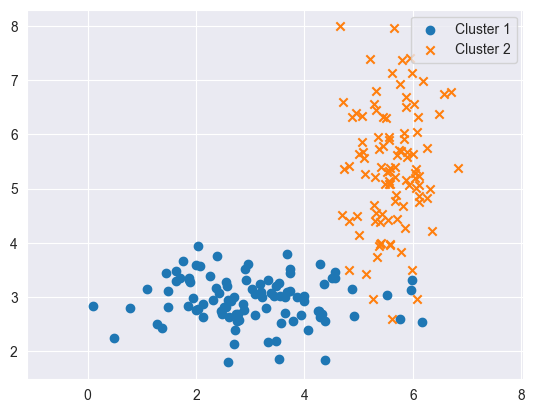

In [24]:
## Generating data set
# Number of samples in the cluster
num_samples = 100

# Mean and covariance for the cluster
mean = [3, 3]
covariance1 = [[1.5, 0],
               [0, 0.2]]  # Wider along x-axis, narrower along y-axis
cluster1 = np.random.multivariate_normal(mean, covariance1, num_samples)
cluster1 = np.c_[cluster1, np.zeros((cluster1.shape[0], 1))]

mean = [5.5, 5.5]
covariance2 = [[0.2, 0],
               [0, 1.5]]  # Wider along y-axis, narrower along x-axis
cluster2 = np.random.multivariate_normal(mean, covariance2, num_samples)
cluster2 = np.c_[cluster2, np.ones((cluster2.shape[0], 1))]

dataset = np.vstack([cluster1, cluster2])
# dataset = load_2d_dataset().values
# last_column = dataset[:, -1]
# cluster1 = dataset[last_column == 0]
# cluster2 = dataset[last_column == 1]

df = pd.DataFrame(data=dataset[:, :-1], columns=['X-axis', 'Y-axis'])
plt.scatter(cluster1[:, 0], cluster1[:, 1], marker='o', label='Cluster 1')
plt.scatter(cluster2[:, 0], cluster2[:, 1], marker='x', label='Cluster 2')
# plt.xlabel('X-axis')
# plt.ylabel('Y-axis')
# plt.title('2D Dataset with two clusters - Wide x-Axis, Narrow y-Axis')
plt.legend()
plt.axis('equal')
plt.show()

In [32]:
df.to_csv('E:\STUDYing\Pre-Master\Study\Research Project\experiment\source-code\evclust\src\evclust\datasets\data.csv', index=False, header=None)

In [26]:
# Traditional ECM clustering
model = ecm(x=df, c=2, beta=2, alpha=1, delta=100, ntrials=10)

[1, 185.75559270214234]
[2, 181.83439961495824]
[3, 181.54286426151546]
[4, 181.52273021630128]
[5, 181.52120847645608]
[6, 181.52103624169658]
[  0.         181.52103624 181.52103624]
[1, 185.75559270214234]
[2, 181.83439961495824]
[3, 181.54286426151546]
[4, 181.52273021630128]
[5, 181.52120847645608]
[6, 181.52103624169658]
[  1.         181.52103624 181.52103624]
[1, 185.75559270214234]
[2, 181.83439961495824]
[3, 181.54286426151546]
[4, 181.52273021630128]
[5, 181.52120847645608]
[6, 181.52103624169658]
[  2.         181.52103624 181.52103624]
[1, 185.75559270214234]
[2, 181.83439961495824]
[3, 181.54286426151546]
[4, 181.52273021630128]
[5, 181.52120847645608]
[6, 181.52103624169658]
[  3.         181.52103624 181.52103624]
[1, 185.75559270214234]
[2, 181.83439961495824]
[3, 181.54286426151546]
[4, 181.52273021630128]
[5, 181.52120847645608]
[6, 181.52103624169658]
[  4.         181.52103624 181.52103624]
[1, 185.75559270214234]
[2, 181.83439961495824]
[3, 181.54286426151546]
[4,

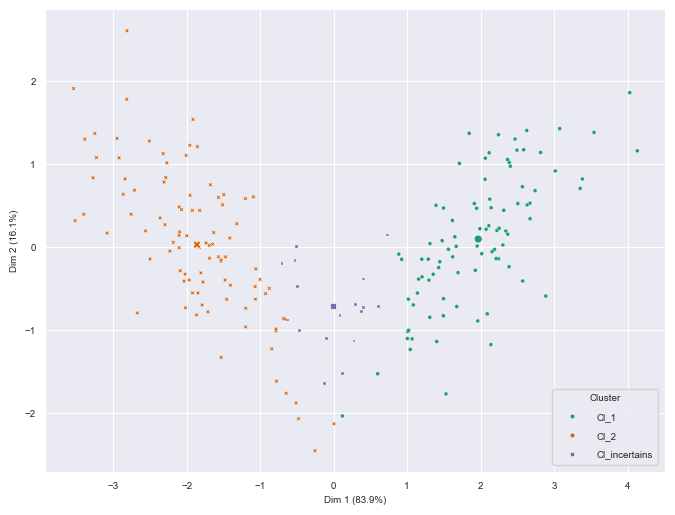

Adjusted Rand Index (ARI): 0.8456245542938297
Silhouette Index (SI): 0.5954421704726481
Maximum Non-specificity value: 2.4112494177434822
Minimum Non-specificity value: 0.002398042125113942
Average Non-specificity value: 0.8683267911831168


In [27]:

# ev_plot(model, X=df)
ev_pcaplot(data=df, x=model, normalize=False)

true_labels = dataset[:, -1]
Y_betP = model['betp']
predicted_labels = np.argmax(Y_betP, axis=1)

# Compute the Adjusted Rand Index (ARI)
ari = adjusted_rand_score(true_labels, predicted_labels)
print(f"Adjusted Rand Index (ARI): {ari}")

# Compute the Silhouette Index (SI)
si = silhouette_score(dataset[:, :-1], predicted_labels)
print(f"Silhouette Index (SI): {si}")

# Calculate Non-specificity
calculate_non_specificity(model)

# (Traditional ECM) Hard partition in 2-D without PCA

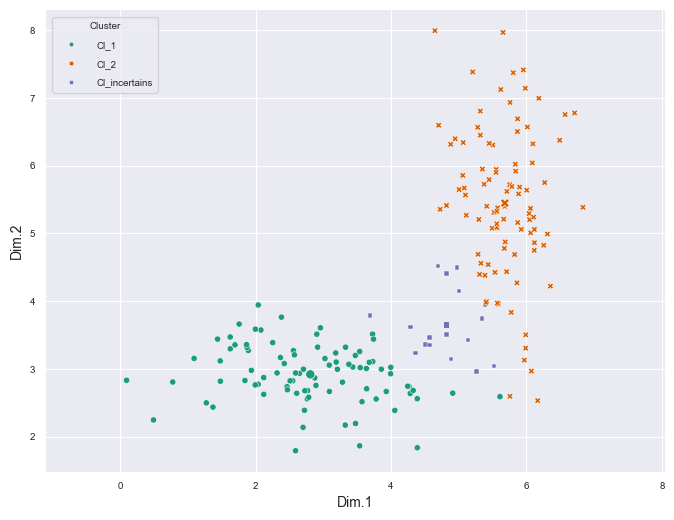

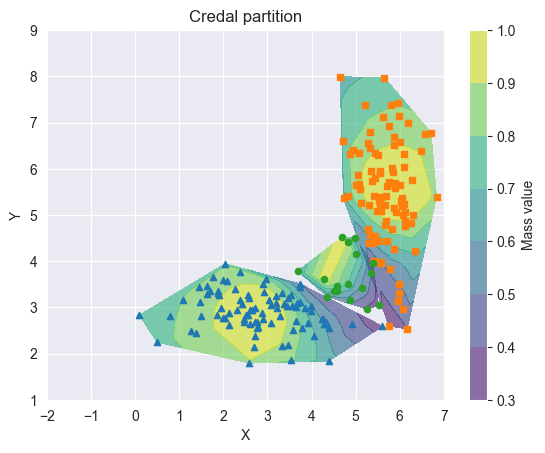

In [28]:
# Hard partition in 2-D without pCA
ev_plot_2D(data=dataset[:, :-1], x=model, normalize=False, cex=20)

marker_list = ['^', 's', 'o']
credal_partition_contour_lines(model, df.values, marker_list)

In [29]:
# Feature weighted ECM clustering
c = 2
d = df.shape[1]
W = np.ones((c, d)) * (1/d)
model = fwecm(x=df, c=c, W=W, beta=2, alpha=1, delta=100, ntrials=10)


Initial weight matrix: 
 [[0.5 0.5]
 [0.5 0.5]]
[1, 46.45264820356958]
[2, 26.730827904374596]
[3, 25.063559638929544]
[4, 24.972777878560343]
[5, 24.951425530616653]
[6, 24.940980404735733]
[7, 24.934946535892028]
[8, 24.9313359772812]
[9, 24.92913712202128]
[10, 24.927778746296838]
[11, 24.92692460184197]
[12, 24.926385332992925]
[13, 24.92603880656436]
[14, 24.925816939631115]
[15, 24.925671788726547]
[16, 24.925576110756804]
[17, 24.92551264510016]
[18, 24.92547032702341]
[19, 24.925442020012394]
[20, 24.92542175496612]
[ 0.         24.92542175 24.92542175]
Initial weight matrix: 
 [[0.5 0.5]
 [0.5 0.5]]
[1, 46.45264820356958]
[2, 26.730827904374596]
[3, 25.063559638929544]
[4, 24.972777878560343]
[5, 24.951425530616653]
[6, 24.940980404735733]
[7, 24.934946535892028]
[8, 24.9313359772812]
[9, 24.92913712202128]
[10, 24.927778746296838]
[11, 24.92692460184197]
[12, 24.926385332992925]
[13, 24.92603880656436]
[14, 24.925816939631115]
[15, 24.925671788726547]
[16, 24.925576110756804]

Weights: [[0.09377941 0.90622059]
 [0.86880933 0.13119067]]
Centers: [[3.27434408 2.95739416]
 [5.67837181 5.63157833]]


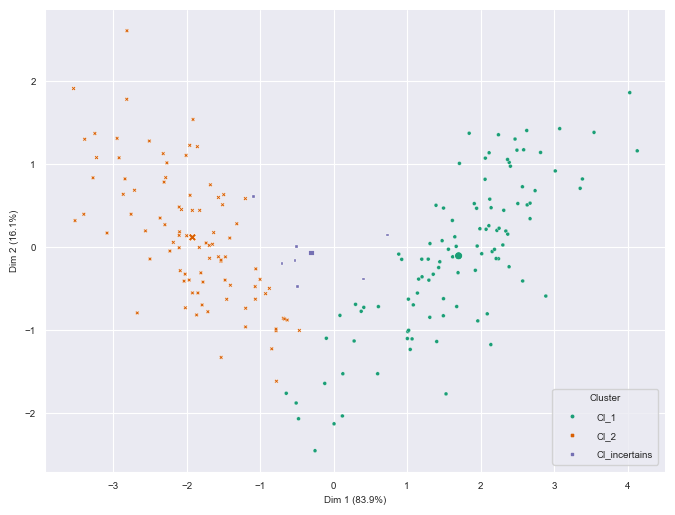

Adjusted Rand Index (ARI): 0.9020088130200377 - J value: 24.92542175496612
Silhouette Index (SI): 0.5863170657413072
Maximum Non-specificity value: 2.810460777736669
Minimum Non-specificity value: 0.0023895875723740473
Average Non-specificity value: 0.7040223346658088


In [30]:
print(f"Weights: {model['W']}")
print(f"Centers: {model['g']}")

# ev_plot(model, X=df)
ev_pcaplot(data=df, x=model, normalize=False)

# Compute the Adjusted Rand Index (ARI)
true_labels = dataset[:, -1]
Y_betP = model['betp']
predicted_labels = np.argmax(Y_betP, axis=1)

ari = adjusted_rand_score(true_labels, predicted_labels)
print(f"Adjusted Rand Index (ARI): {ari} - J value: {model['crit']}")

# Compute the Silhouette Index (SI)
si = silhouette_score(dataset[:, :-1], predicted_labels)
print(f"Silhouette Index (SI): {si}")

# Calculate Non-specificity
calculate_non_specificity(model)

# (Weighted ECM) Hard partition in 2-D without PCA

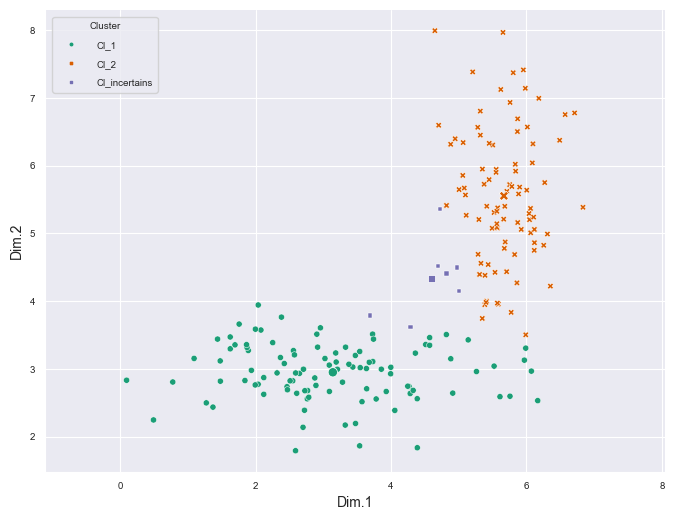

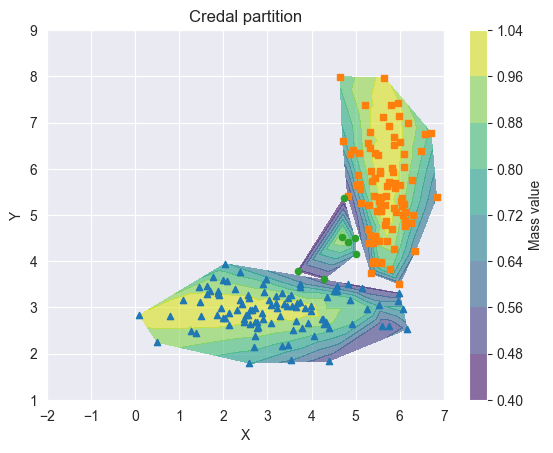

In [31]:
ev_plot_2D(data=dataset[:, :-1], x=model, normalize=False, cex=20)

marker_list = ['^', 's', 'o']
credal_partition_contour_lines(model, df.values, marker_list)